# Texas

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import helper_functions
from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import create_dataset
from helper_functions import fit_model
from helper_functions import test_RMSE
from helper_functions import train_RMSE
# from helper_functions import preprocess_data
from helper_functions import plot_loss
from helper_functions import LSTM_prediction_plot

Using TensorFlow backend.


In [2]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    import warnings
    warnings.filterwarnings('ignore')
    import itertools
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error as MSE
    from statsmodels.tsa.seasonal import seasonal_decompose
    

    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test

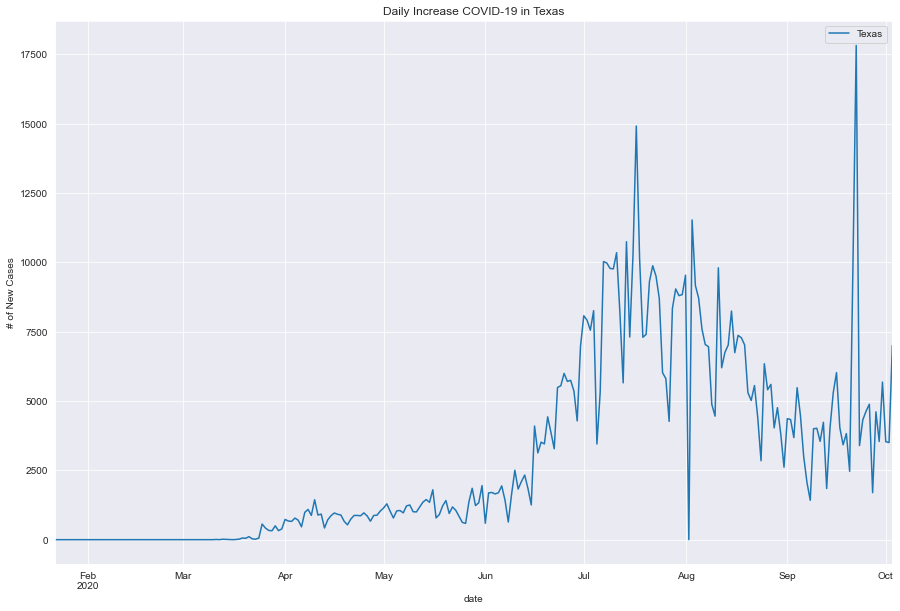

In [3]:
df = pd.read_csv('national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# Texas
tx = df['TX_positiveIncrease']
tx.plot(figsize=(15, 10), label='Texas')

plt.ylabel('# of New Cases')
plt.title('Daily Increase COVID-19 in Texas')
plt.legend()
plt.show();


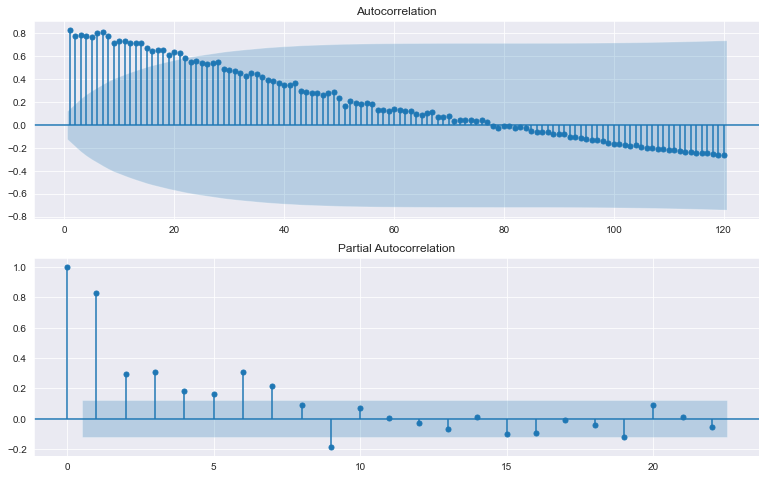

In [4]:
acf_pacf(tx)

In [5]:
decompose_time_series(tx)

NameError: name 'fl' is not defined

In [ ]:
tx_results = pm.auto_arima(tx, information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=7, max_q=21,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
tx_results

In [ ]:
tx_train, tx_test = train_test(tx)

In [ ]:
pdq = (0, 1, 1)
pdqs = (1, 0, 1, 7)
train, test, results = fit_model(tx_train, tx_test, pdq=pdq, pdqs=pdqs)

In [ ]:
train_RMSE(tx_train, results, display = True)

In [ ]:
test_RMSE(tx_train, tx_test, pdq, pdqs, display=True)

# LSTM

In [ ]:
tx_train, tx_val, tx_test = preprocess_data(tx, 'TX_positiveIncrease')

print(f"Train has {len(tx_train)} values")
print(f"Validation has {len(tx_val)} values")
print(f"Test has {len(tx_test)} values")

In [ ]:
look_back = 1

X_train, y_train = create_dataset(tx_train, look_back)
X_val, y_val = create_dataset(tx_val, look_back)
X_test, y_test = create_dataset(tx_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100)], 
                    verbose=1, shuffle=False)

model.summary()

In [ ]:
from sklearn.metrics import mean_absolute_error as MAE

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train[0], train_predict[:,0]))

print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train[0], 
                                                   train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test[0], test_predict[:,0]))

print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test[0], 
                                                  test_predict[:,0])))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(11)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:11], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][1:12], '-', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('CA Increase in COVID-19 Cases', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();